# Problem Statement
---
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

# Business Goal
---
The goal is to develop an accurate, data-driven forecasting model for predicting daily sales at Rossmann’s 1,115 stores across Europe for the next six weeks. By incorporating key influencing factors such as promotional campaigns, competition, holidays, seasonality, and locality, the model will replace the current manual forecasting approach used by store managers. The aim is to improve forecasting accuracy, optimize inventory management, and reduce waste due to product expiry, ultimately leading to better decision-making and enhanced operational efficiency across all stores.

# 1. Import Required Libraries for the Project
---

In [1]:
# Import maths tools:
import pandas as pd
import numpy as np

# Import visulaization tools:
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML Libraries:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import boxcox
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

# Import Warnings:
import warnings
warnings.filterwarnings('ignore')

# 2. Data Preparation
---

### Starting with the Store Data
- **Store -** An Id that represents the store.
- **StoreType -** Differentiates between 4 different store models: a, b, c, d.
- **Assortment -** Describes an assortment level: a = basic, b = extra, c = extended.
- **CompetitionDistance -** Describes the distance in meters to the nearest competitor store.
- **CompetitionOpenSince[Month/Year] -** Gives the approximate year and month of the time the nearest competitor was opened.
- **Promo2 -** Promo2 is a continuing and consecutive promotion for some stores:
0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week] -** Describes the year and calendar week when the store started participating in Promo2
- **PromoInterval -** Describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Read store Data
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
# print shape of store data
print('Shape of Store Data', store.shape)

Shape of Store Data (1115, 10)


In [4]:
# lets check for the missing values in the Store Dataset
print(f"Total Missing Value:\n{'-' * 30}\n{store.isnull().sum()}\n")
print(f"Missing value in Percentage:\n{'-' * 30}\n{store.isnull().mean() * 100}")

Total Missing Value:
------------------------------
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Missing value in Percentage:
------------------------------
Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64


#### Handling Missing Data in Store Dataset
- First check for the distribution of the data so that after imputing the values distribution has to remain same.
- For now we don't have to focus on the data to be normally distributed we will fix it later.

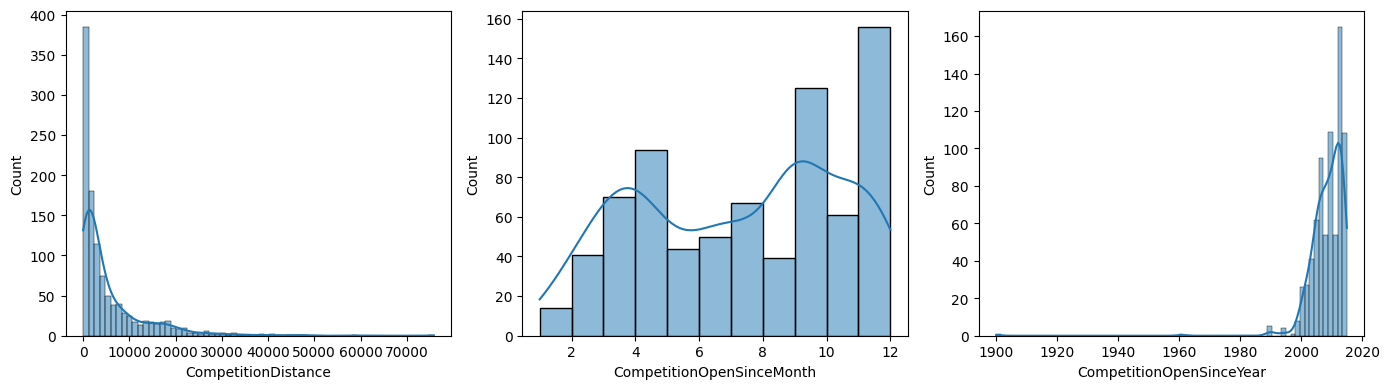

In [5]:
# let's first plot distribution plots for CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# plot the graphs: 
sns.histplot(data=store.CompetitionDistance, kde=True, ax=axes[0])
sns.histplot(data=store.CompetitionOpenSinceMonth, kde=True, ax=axes[1])
sns.histplot(data=store.CompetitionOpenSinceYear, kde=True, ax=axes[2])

plt.tight_layout()
plt.show()

- We can impute data in CompetitionDistance but imputing data in CompetitionOpenSinceMonth and CompetitionOpenSinceYear is quite difficult using this data, it will change the complete distribution of the data and will change the meaning of entire data set.
- So, removing columns CompetitionOpenSinceMonth and CompetitionOpenSinceYear will be a good option here.

In [6]:
# In CompetitionDistance impute using mean Value it will not affect the distribution of the column.
store.CompetitionDistance.fillna(store.CompetitionDistance.mean(), inplace=True)

# drop columns CompetitionOpenSinceMonth and CompetitionOpenSinceYear
store.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], inplace=True)

In [7]:
# Let's evaluate whether the missing data in Promo2SinceWeek, Promo2SinceYear, and PromoInterval is random or results from the company not participating in promotional events.
filtered_store = store[(store['Promo2SinceWeek'].isnull()) & 
                       (store['Promo2SinceYear'].isnull()) & 
                       (store['PromoInterval'].isnull()) &
                       (store['Promo2'] == 0)]
filtered_store.shape

(544, 8)

- Based on the observation, we can drop the columns Promo2SinceWeek, Promo2SinceYear, and Promo2, as their essence can be effectively captured through the Promo2 column.
- And imputing 48% of the value in the dataset can manupulate the meaning of the data.

In [8]:
# drop Promo2SinceWeek, Promo2SinceYear, and Promo2
store.drop(columns=['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], inplace=True)

### Import Sales Data for Stores.
- **Store -** A unique Id for each store.
- **DayOfWeek -** Describes the day of the week (1 - Monday till 7 - Sunday).
- **Date -** Describes the date on the day.
- **Sales -** The turnover for any given day (this is what you are forecasting).
- **Customers -** The number of customers on a given day.
- **Open -** An indicator for whether the store was open: 0 = closed, 1 = open.
- **StateHoliday -** Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday -** Indicates if the (Store, Date) was affected by the closure of public schools

In [9]:
# Read sales data
sales = pd.read_csv('train.csv')
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
# Check for the shape of sales DF
sales.shape

(1017209, 9)

In [11]:
# Check for the missing value if any.
sales.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

- There is no null vlues in the sales data set. so lets just proceed on mearging the datasets and then fo the further analysis.

### Merge Operation.
Merge Sales and Store Data Set

In [12]:
merged_df = sales.merge(right=store, how='inner', on='Store')
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0


In [13]:
# Check for the shape of merged DF
merged_df.shape

(1017209, 13)

In [14]:
# Check for the null values in merged DF
merged_df.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

In [15]:
# Check for the info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   DayOfWeek            1017209 non-null  int64  
 2   Date                 1017209 non-null  object 
 3   Sales                1017209 non-null  int64  
 4   Customers            1017209 non-null  int64  
 5   Open                 1017209 non-null  int64  
 6   Promo                1017209 non-null  int64  
 7   StateHoliday         1017209 non-null  object 
 8   SchoolHoliday        1017209 non-null  int64  
 9   StoreType            1017209 non-null  object 
 10  Assortment           1017209 non-null  object 
 11  CompetitionDistance  1017209 non-null  float64
 12  Promo2               1017209 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 100.9+ MB


In [16]:
# Change Dtype of Date to Date Time format
merged_df.Date = pd.to_datetime(merged_df.Date, format="%Y-%m-%d")

In [17]:
# Check value_counts of all categorical columns
cat_cols = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2']
for i in cat_cols:
    print(f"{merged_df[i].value_counts()}\n{'-'*30}")

DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64
------------------------------
Open
1    844392
0    172817
Name: count, dtype: int64
------------------------------
Promo
0    629129
1    388080
Name: count, dtype: int64
------------------------------
StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64
------------------------------
SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64
------------------------------
StoreType
a    551627
d    312912
c    136840
b     15830
Name: count, dtype: int64
------------------------------
Assortment
a    537445
c    471470
b      8294
Name: count, dtype: int64
------------------------------
Promo2
1    509178
0    508031
Name: count, dtype: int64
------------------------------


In [18]:
merged_df.StateHoliday = np.where(((merged_df.StateHoliday == 0) | (merged_df.StateHoliday == '0')),
                                  'd', merged_df.StateHoliday)

In [19]:
# Remove all the rows when store is closed (when store is not open then there will be no sale):
merged_df = merged_df[merged_df['Open']!=0]

# Remove all those stores which has 0 sales:
merged_df = merged_df[merged_df['Sales']!=0]

# Drop Open column as it has only one value now:
merged_df.drop(columns='Open', inplace=True)

# Exploratory Data Analysis:
---
Now let's perform analysis on the data set: 
1. Univariate Analysis.
2. Bivariate Analysis.
3. Multivariate Analysis.

### 1. Univariate Analysis:

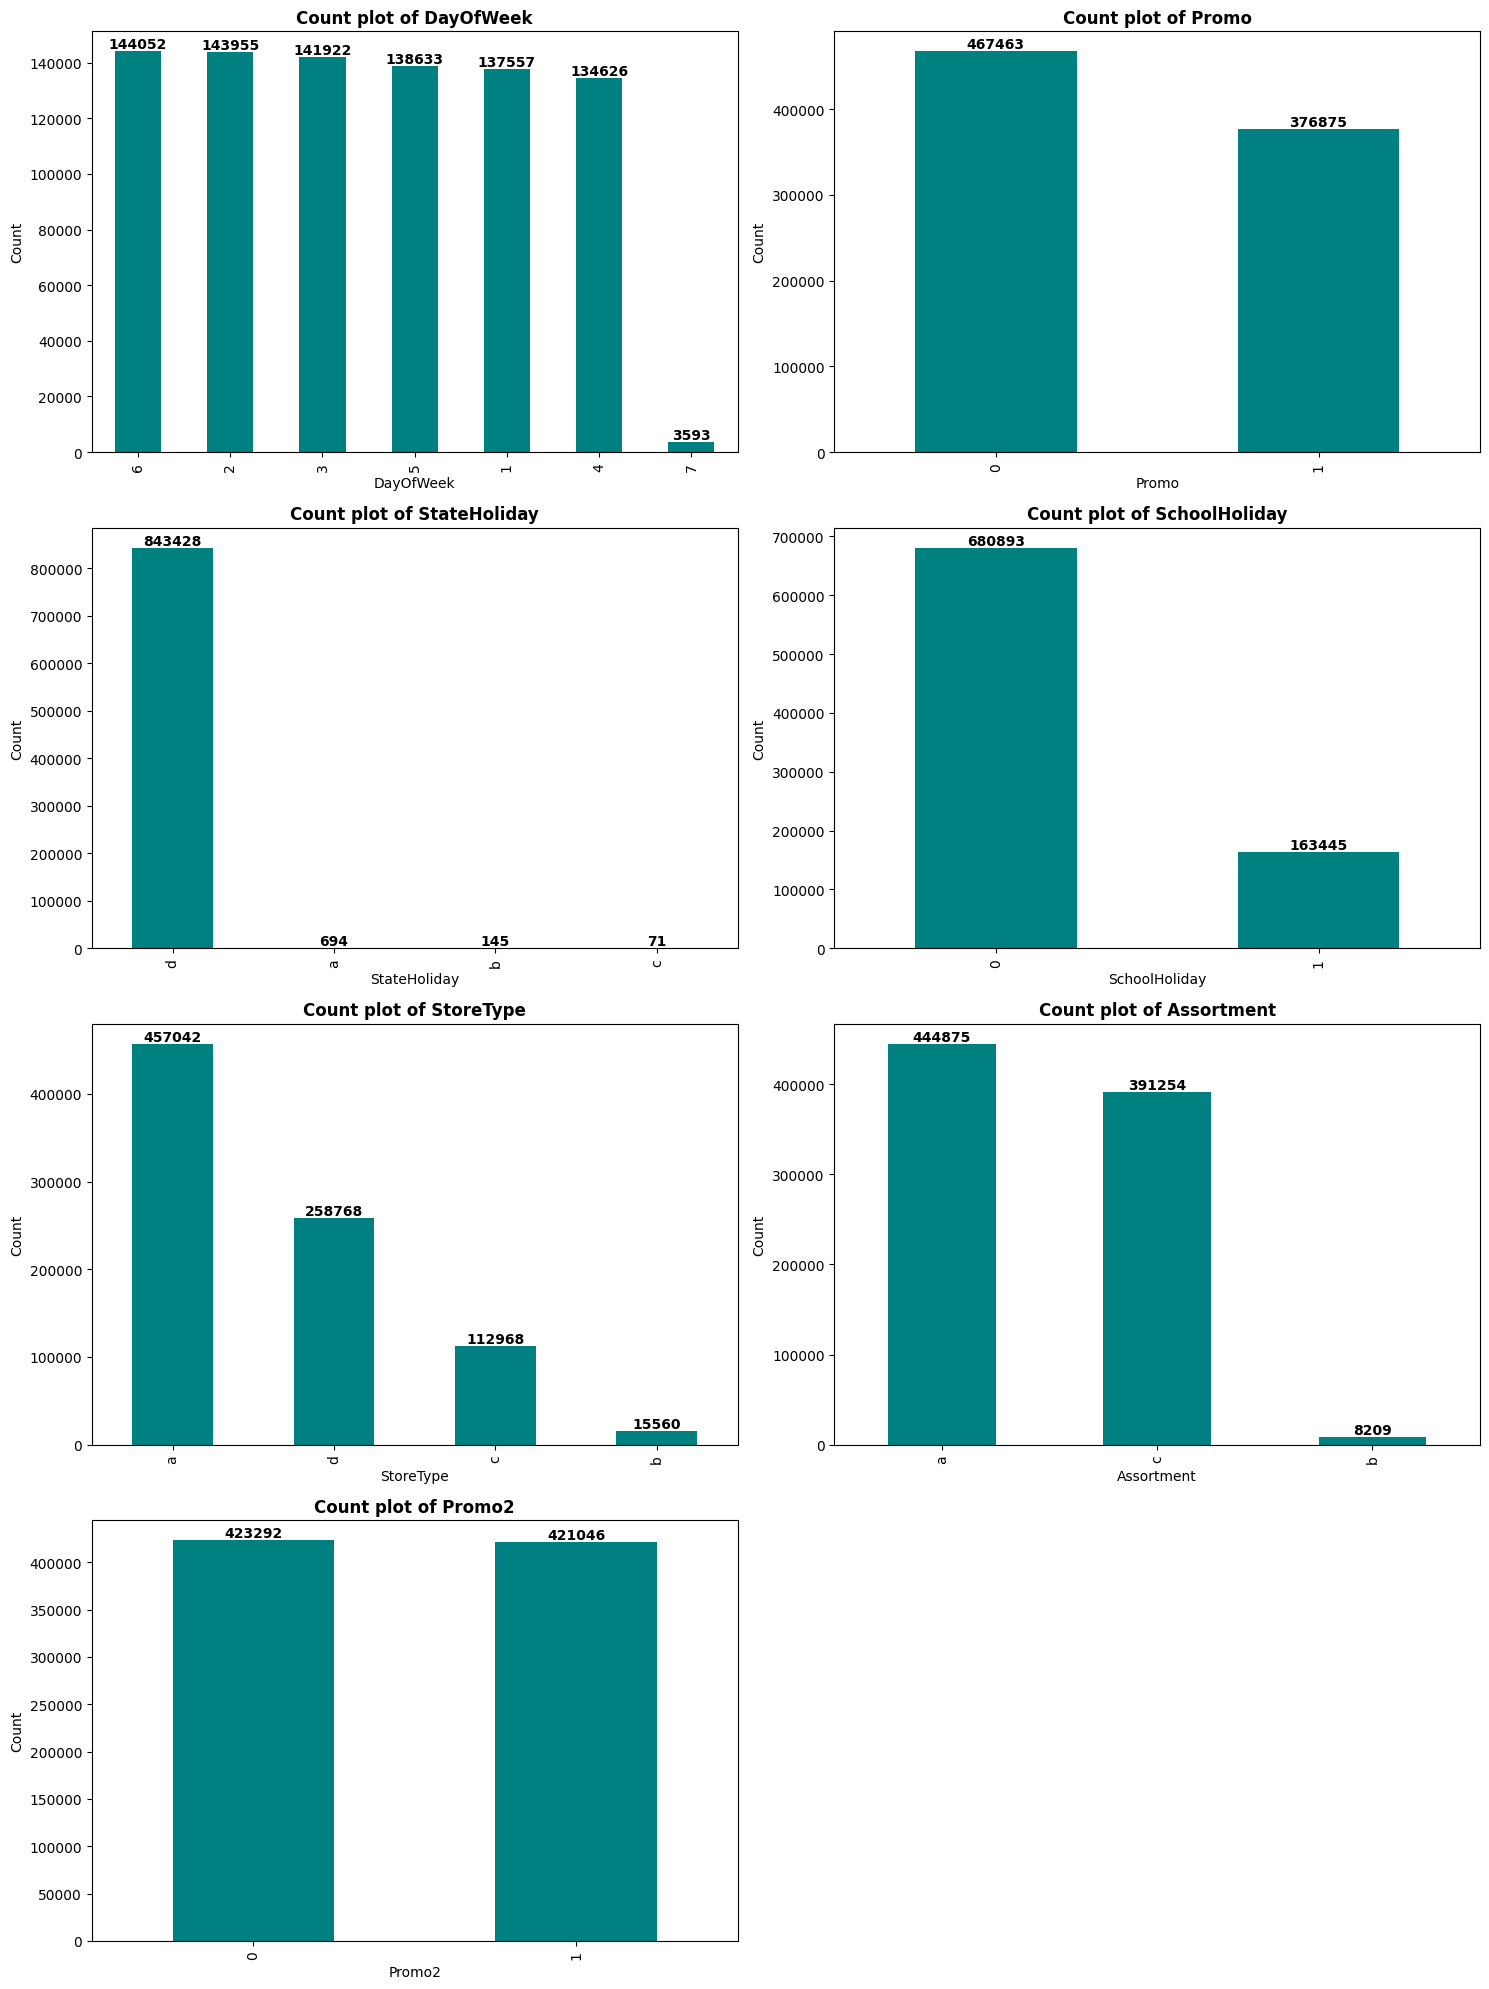

In [20]:
# Plot Bar chart for Categorical Columns:
cat_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
axes = axes.flatten()
# run loop for plotting of graphs
for idx, col in enumerate(cat_cols):
    count = merged_df[col].value_counts()
    count.plot(kind='bar', ax=axes[idx], color='teal')
    axes[idx].set_title(f"Count plot of {col}", fontweight='bold')
    axes[idx].set_ylabel('Count')
    
    for i, j in enumerate(count):
        axes[idx].text(x=i, y=j, s=j, fontweight='bold', ha='center', va='bottom')

# Hide any unused subplots
for idx in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[idx])
    
    
plt.tight_layout()
plt.show()

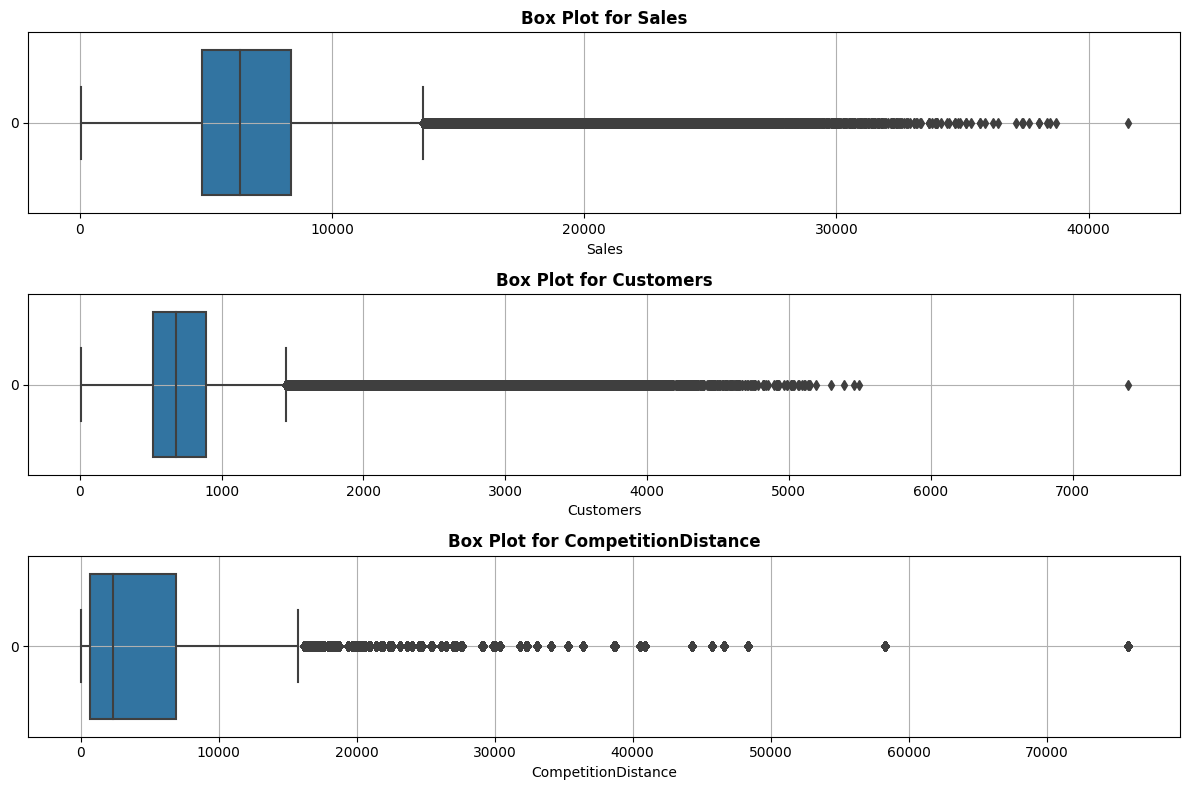

In [21]:
# plot box plot to see the distribution of the numerical columns and check for the outliers
num_cols = ['Sales', 'Customers', 'CompetitionDistance']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

for idx, col in enumerate(num_cols):
    sns.boxplot(data=merged_df[col], ax=axes[idx], orient='h')
    axes[idx].set_title(f"Box Plot for {col}", fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].grid(True)
    
plt.tight_layout()
plt.show()

**Observations for Categorical Data**:
1. On sundays very less number of store opens that's why we have encountered low count on sunday.
2. Most of the stores are of 'a' type.
3. Only few store who has category 'b' (extra) assortment otherwise all the stores have basic and extended categories.
4. There are approx equal number of stores who are participating in Promotional events.

**Observations for Numerical Data**:
- The numerical columns contain numerous outliers, but in this context, addressing them solely through univariate analysis is insufficient. A deeper investigation is necessary to determine whether these outliers hold specific significance or underlying patterns.

### 2. Bivariate Analysis:
- Here we are going to see how all other features affecting the sales.

In [22]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,d,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,d,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,d,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,d,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,d,1,a,a,29910.0,0


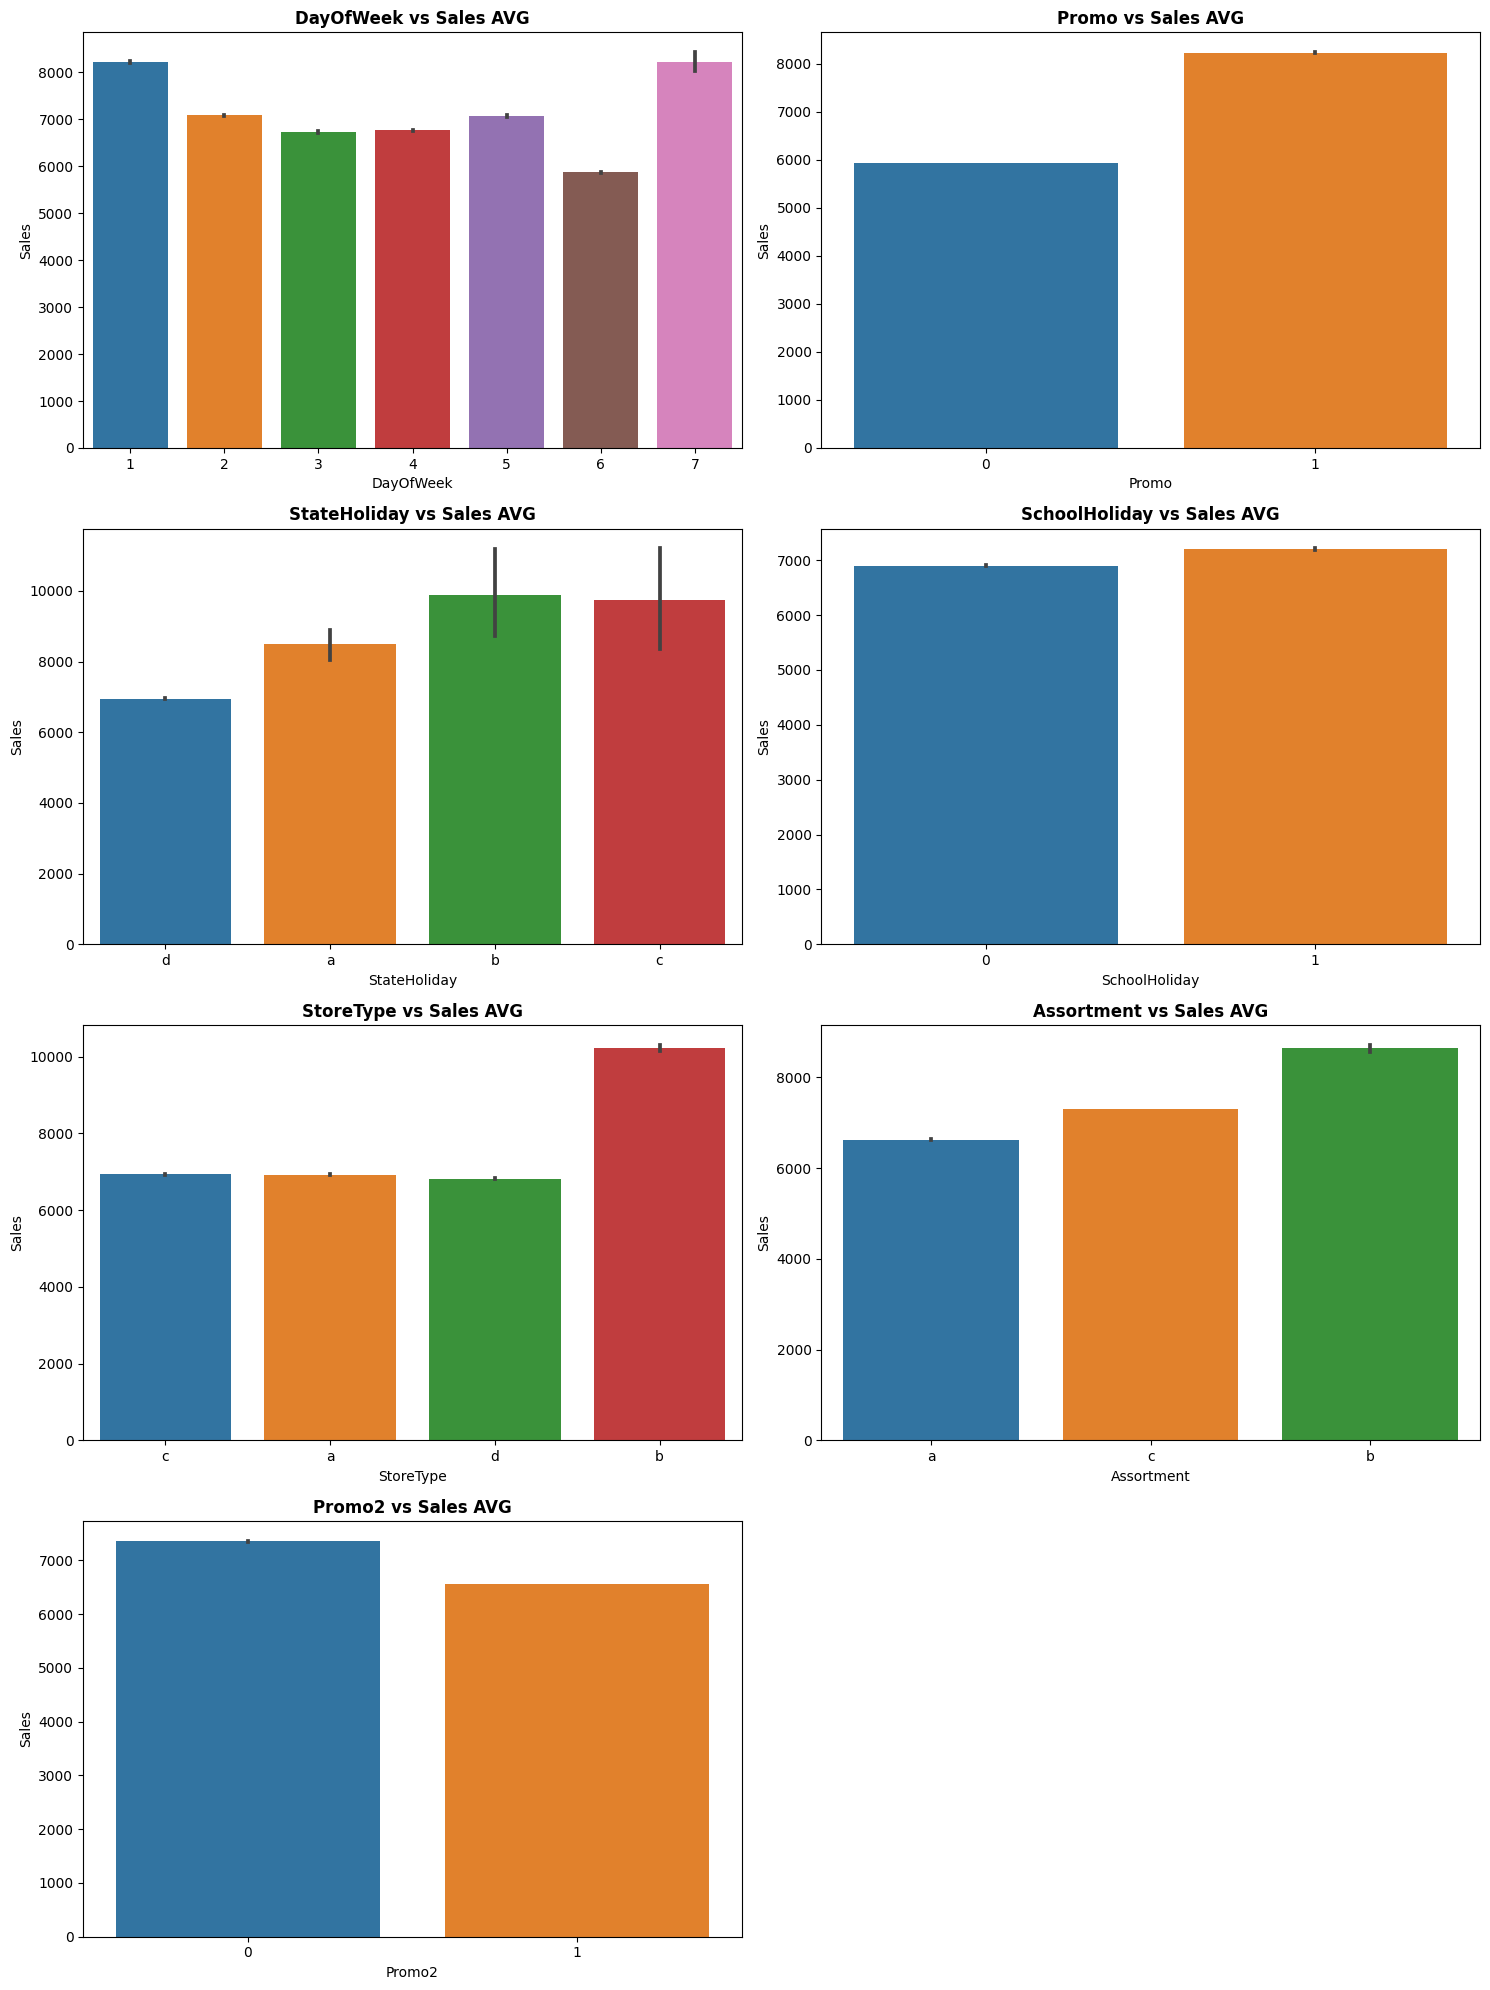

In [23]:
# Use Sales columns and other categorical columns
cat_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()
for idx, col in enumerate(cat_cols):
    sns.barplot(data=merged_df, x=col, y='Sales', ax=axes[idx])
    axes[idx].set_title(f"{col} vs Sales AVG", fontweight='bold')
    
# Hide any unused subplots
for idx in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[idx])
    
plt.tight_layout()
plt.show()

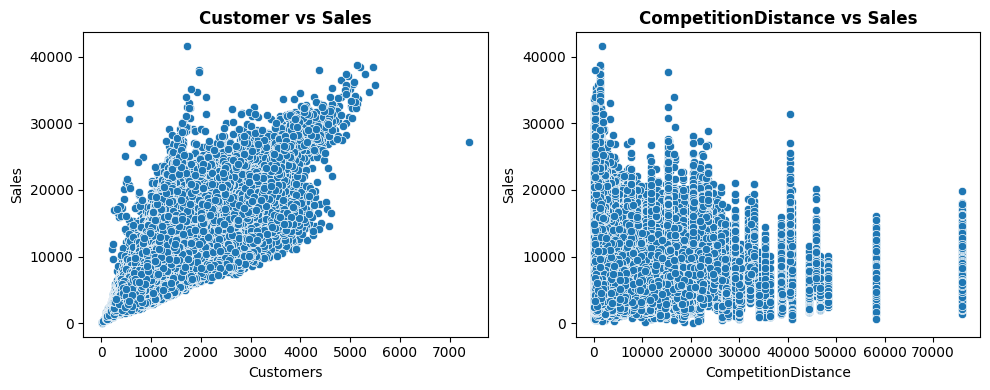

In [24]:
# Use numerical column to see the trend for Sales:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

sns.scatterplot(data=merged_df, x='Customers', y='Sales', ax=axes[0])
axes[0].set_title("Customer vs Sales", fontweight='bold')

sns.scatterplot(data=merged_df, x='CompetitionDistance', y='Sales', ax=axes[1])
axes[1].set_title("CompetitionDistance vs Sales", fontweight='bold')

plt.tight_layout()
plt.show()

**Observations for Categorical Data:**
1. As per the graph above, shops are experiencing higher demand for purchases, indicating that customer traffic and buying activity are concentrated in certain outlets.
2. Shops with promotional activities tend to sell more products, highlighting the impact of marketing campaigns on driving sales volumes.
3. Despite being fewer in number, the 'b' category Assortment maintains intact average sales, suggesting that these shops cater to specific or high-value customer needs.
4. When comparing total sales across categories, it is evident that categories with a higher frequency of stores contribute more to overall sales, but average sales provide a more accurate insight into the performance and efficiency of each category.

**Observations for Numerical Data**:
1. It is quite obvious to get linear trend on customer vs sales data.
2. Compitition vs sales is not showing any relationship.

In [25]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,d,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,d,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,d,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,d,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,d,1,a,a,29910.0,0


### 3. Multivariate Analysis:
- For this first we need to do one hot encoding on categorical data.

**Before moving forward lets just fix some things**
1. Set Date column as index column.
2. Remove Store column.

In [26]:
# Set Date column as Index column:
merged_df = merged_df.set_index(merged_df.Date)

# Drop columns:
merged_df.drop(columns=['Date', 'Store'], inplace=True)

In [27]:
merged_df_encoded = pd.get_dummies(merged_df, columns=['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment'],
                                   dtype='int', drop_first=True)
merged_df_encoded.head()

,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,5263,555,1,1,1270.0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2015-07-31,6064,625,1,1,570.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2015-07-31,8314,821,1,1,14130.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2015-07-31,13995,1498,1,1,620.0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
2015-07-31,4822,559,1,1,29910.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [28]:
# Check for the corr
corr = merged_df_encoded.corr()
corr

,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
Sales,1.000000,0.823552,0.368199,0.038635,-0.036401,-0.127556,0.019346,-0.032899,-0.026345,0.016718,-0.157943,0.026723,0.012380,0.008237,-0.019606,0.144685,-0.002891,-0.028627,0.053841,0.103257
Customers,0.823552,1.000000,0.182859,0.024915,-0.148425,-0.202207,0.008183,-0.024767,-0.007715,0.021028,-0.115957,0.110600,0.030188,0.018434,-0.049451,0.430137,0.051685,-0.259187,0.322247,-0.024493
Promo,0.368199,0.182859,1.000000,0.028971,-0.002389,-0.000316,0.081464,0.082210,0.091272,0.066065,-0.407237,-0.058698,-0.002677,-0.008234,-0.002165,-0.017843,0.002163,0.000989,-0.012921,0.000939
SchoolHoliday,0.038635,0.024915,0.028971,1.000000,-0.004273,-0.008244,0.060233,0.039176,0.033698,0.039899,-0.200545,-0.028253,0.025377,0.018717,-0.012593,-0.002988,0.002764,-0.003301,-0.002782,-0.002429
CompetitionDistance,-0.036401,-0.148425,-0.002389,-0.004273,1.000000,-0.141786,-0.001586,-0.001742,-0.000470,-0.001625,-0.001353,0.043291,0.005826,-0.003995,-0.010188,-0.077043,-0.097952,0.129404,-0.054228,0.154625
Promo2,-0.127556,-0.202207,-0.000316,-0.008244,-0.141786,1.000000,0.000907,0.001405,-0.001054,0.001515,0.001647,-0.028628,-0.005479,-0.003980,0.010308,-0.057561,-0.000861,0.094112,-0.013147,0.009735
DayOfWeek_2,0.019346,0.008183,0.081464,0.060233,-0.001586,0.000907,1.000000,-0.203785,-0.197455,-0.200940,-0.205621,-0.029638,-0.005942,-0.004158,0.012972,-0.009949,0.000764,0.001089,-0.007208,0.000286
DayOfWeek_3,-0.032899,-0.024767,0.082210,0.039176,-0.001742,0.001405,-0.203785,1.000000,-0.195772,-0.199228,-0.203868,-0.029385,-0.005891,0.001750,0.009649,-0.009124,0.000564,0.001137,-0.006611,0.000269
DayOfWeek_4,-0.026345,-0.007715,0.091272,0.033698,-0.000470,-0.001054,-0.197455,-0.195772,1.000000,-0.193039,-0.197536,-0.028472,-0.005708,0.008354,-0.034204,-0.006085,0.001195,-0.000108,-0.004414,0.000553
DayOfWeek_5,0.016718,0.021028,0.066065,0.039899,-0.001625,0.001515,-0.200940,-0.199228,-0.193039,1.000000,-0.201022,-0.028975,0.006391,0.002560,0.001015,-0.007697,0.000598,0.001224,-0.005567,-0.000023


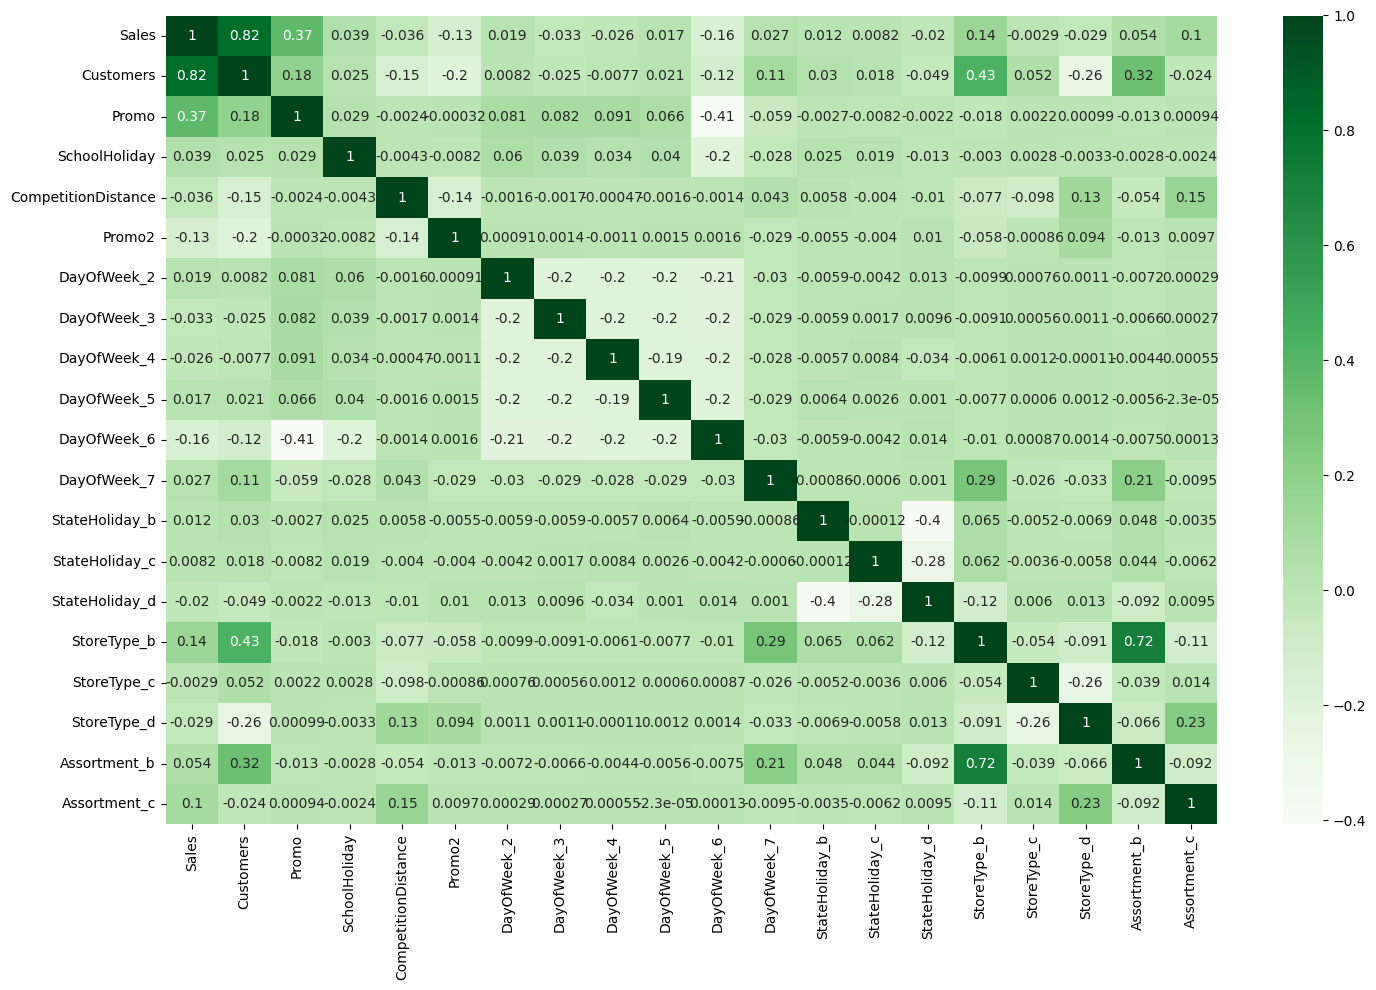

In [29]:
# Plot heatmap for corr data
plt.figure(figsize=(15, 10))
sns.heatmap(data=corr, annot=True, cmap='Greens')

plt.tight_layout()
plt.show()

**Observation**
- The Customer column has a significant impact on Sales, while the Promo column also shows a notable influence on Sales, indicating its effectiveness in driving purchases.
- Appart from the Sales, Customer, Promo, Promo2, and Assortment_c, no other columns are affecting the Sales column so it is better to keep only these columns for future analysis and model training.

# Time Series Data Preparation
---

In [30]:
merged_df_encoded.shape

(844338, 20)

In [31]:
# Select only required columns:
merged_df_encoded = merged_df_encoded[['Customers', 'Promo', 'Promo2', 'Sales']]

In [32]:
# As we have a lot of data point we need to aggregate now:
daily_data = merged_df_encoded.resample('D').agg({
    'Sales': 'mean',       # Mean of sales over the week
    'Customers': 'mean',   # Mean of customers over the week
    'Promo': 'sum',       # Sum of promos (assuming it's a binary or categorical column)
    'Promo2': 'sum'       # Sum of promo2
})
daily_data.head()

,Sales,Customers,Promo,Promo2
Date,,,,
2013-01-01,5719.705882,1146.529412,0,5
2013-01-02,6255.471647,750.742574,0,570
2013-01-03,5723.913436,686.239856,0,569
2013-01-04,5991.835740,705.899819,0,568
2013-01-05,5376.326107,621.022584,0,568


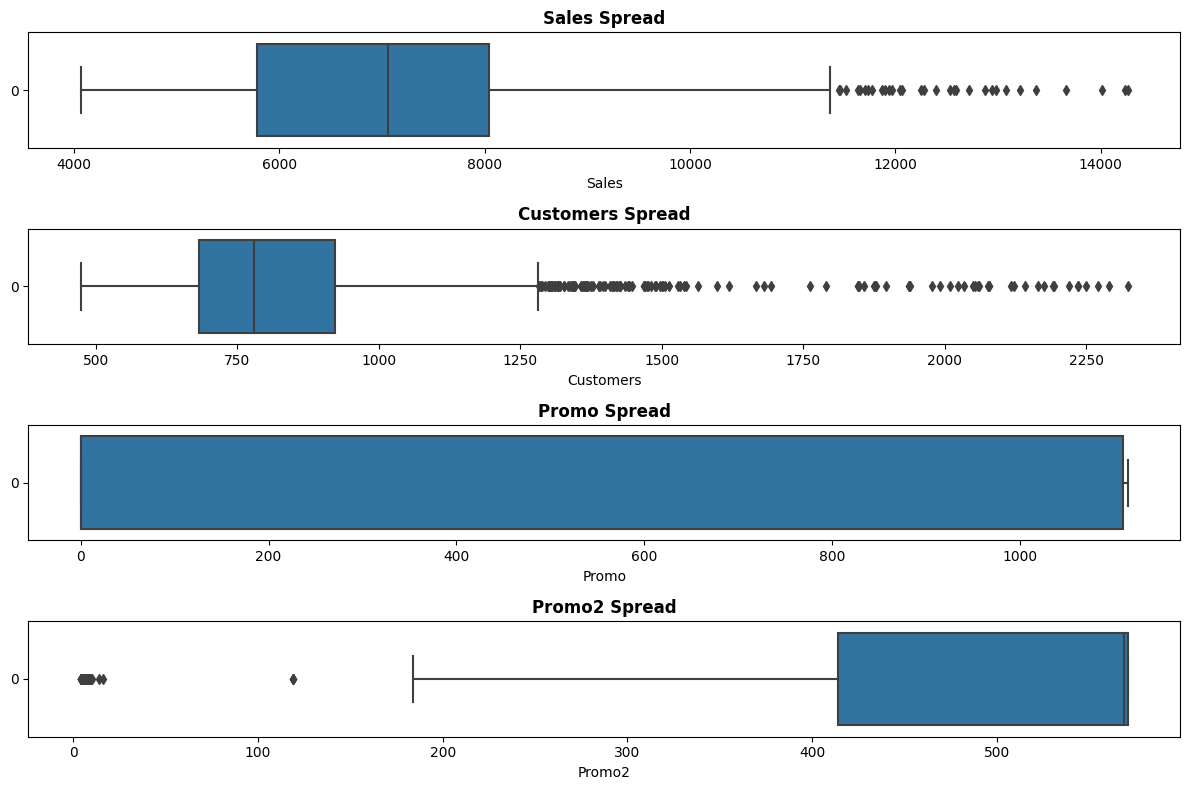

In [33]:
# before Moving ahead lets check for the outliers:
# plot box plot for all the columns:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 8))
for idx, col in enumerate(daily_data.columns):
    sns.boxplot(data=daily_data[col], orient='h', ax=axes[idx])
    axes[idx].set_title(f"{col} Spread", fontweight='bold')
    axes[idx].set_xlabel(col)
    
plt.tight_layout()
plt.show()

In [34]:
# Cap outliers to the wishkers
cols = ['Sales', 'Customers', 'Promo2']
for i in cols:
    q1 = daily_data[i].quantile(0.25) # calculate 25th percentile value
    q3 = daily_data[i].quantile(0.75) # calculate 75th percentile value
    iqr = q3 - q1
    # Calculate wishkers
    lower_wishker = q1 - 1.5 * iqr
    upper_wishker = q3 + 1.5 * iqr
    
    # Update data
    daily_data[i] = daily_data[i].apply(lambda x: lower_wishker if x < lower_wishker
                                              else (upper_wishker if x > upper_wishker else x))

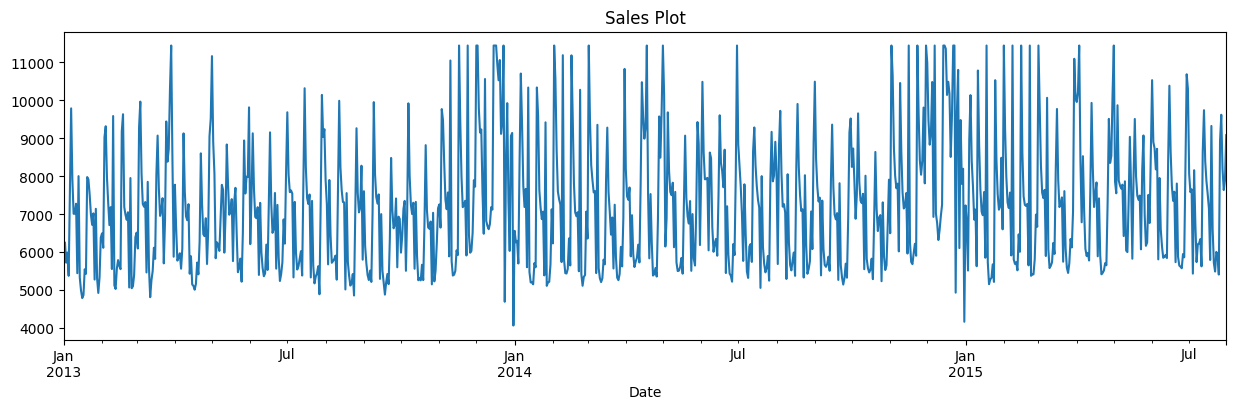

In [35]:
# Plot Sales
daily_data.Sales.plot(figsize=(15,4))
plt.title('Sales Plot')
plt.show()

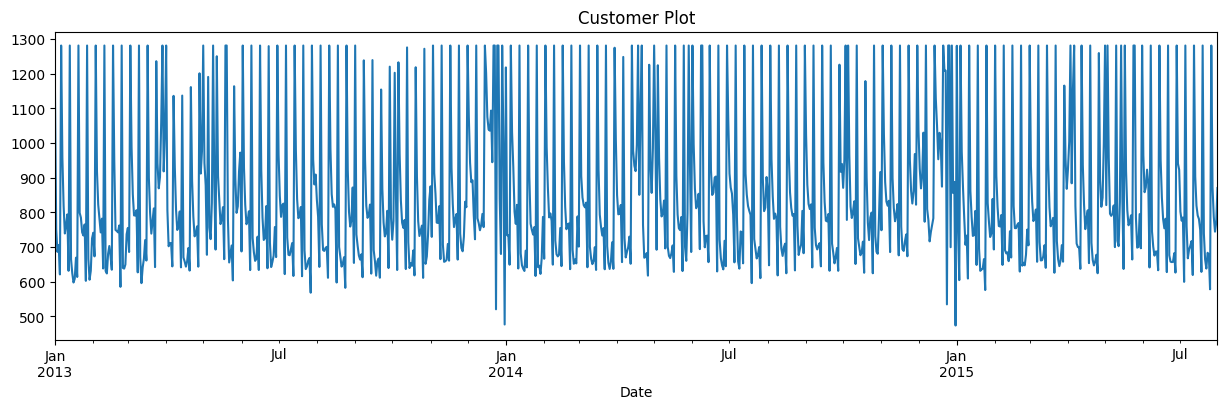

In [36]:
# Plot Customer
daily_data.Customers.plot(figsize=(15,4))
plt.title('Customer Plot')
plt.show()

# Time Series Decomposition
---
1. Additive
2. Multiplicative

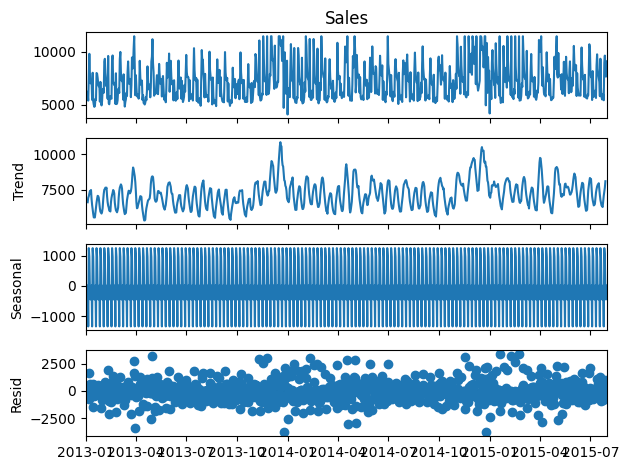

In [37]:
# Additive Decomposition
add_decomp = sm.tsa.seasonal_decompose(daily_data.Sales, model='additive')
fig = add_decomp.plot()
plt.show()

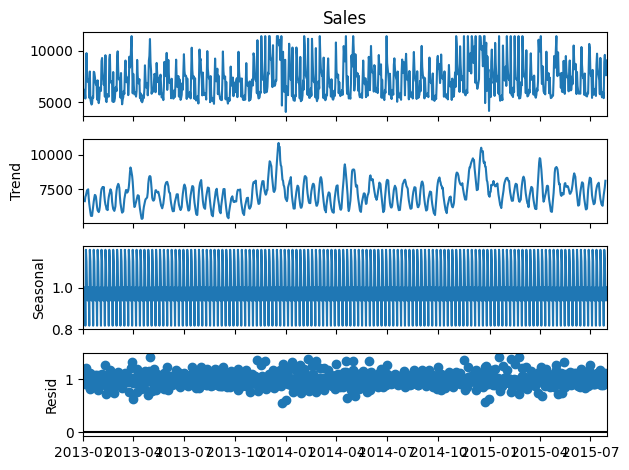

In [38]:
# Multiplicative Decomposition
mult_decomp = sm.tsa.seasonal_decompose(daily_data.Sales, model='multiplicative')
fig = mult_decomp.plot()
plt.show()

# Stationarity Test
---
### 1. Augmented Dickey-Fuller (ADF) test:
   - **Null Hypothesis (H0):** The time series is non-stationary
   - **Alternative Hypothesis (H1):** The time series in stationary
    
   **Observations to be done**
   - If the p-value < significance level (e.g., 0.05), reject H₀: The series is stationary.
   - If the p-value ≥ significance level, fail to reject H₀: The series is non-stationary.

### 2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
   - **Null Hypothesis (H0):** The time series is Stationary
   - **Alternative Hypothesis (H1):** The time series is non-stationary

   **Observations to be done**
   - If the p-value < significance level (e.g., 0.05), reject H₀: The series is non-stationary.
   - If the p-value ≥ significance level, fail to reject H₀: The series is stationary.

In [39]:
# ADF Test:
for col in daily_data.columns:
    adf_test = sm.tsa.adfuller(daily_data[col])
    print(f"\n{col} ADF Test\n{'-'*40}")
    print('ADF Statistics:', adf_test[0]) # at 0 index it will provide Statistics
    print('Critical Value @ 5%:', adf_test[4]['5%']) # at 4th index we will find critical value
    print('P-Value: ', adf_test[1])


Sales ADF Test
----------------------------------------
ADF Statistics: -5.493207023597565
Critical Value @ 5%: -2.8646730402041443
P-Value:  2.15204582786093e-06

Customers ADF Test
----------------------------------------
ADF Statistics: -5.975762518676848
Critical Value @ 5%: -2.8646901138095378
P-Value:  1.889231841502933e-07

Promo ADF Test
----------------------------------------
ADF Statistics: -8.643042128005307
Critical Value @ 5%: -2.8646901138095378
P-Value:  5.3615629048940016e-14

Promo2 ADF Test
----------------------------------------
ADF Statistics: -2.17351902591827
Critical Value @ 5%: -2.8646832620852853
P-Value:  0.21599649760089296


**Conclusion**:
- **Sales:**  Since the ADF statistic is much lower than the critical value, and the p-value is very small (significantly less than 0.05), we can reject the null hypothesis and conclude that the **"Sales" column is stationary.**
- **Customer:** The ADF statistic is lower than the critical value, and the p-value is also small. Thus, we can reject the null hypothesis and conclude that the **"Customers" column is stationary.**
- **Promo:** The ADF statistic is much lower than the critical value, and the p-value is extremely small. So, we reject the null hypothesis and conclude that the **"Promo" column is stationary.**
- **Promo2:** The ADF statistic is greater than the critical value, and the p-value is greater than 0.05. Thus, we fail to reject the null hypothesis, meaning that the **"Promo2" column is non-stationary.**

In [40]:
# KPSS test
for col in daily_data.columns:
    kpss_test = sm.tsa.kpss(daily_data[col])
    print(f"\n{col} KPSS Test\n{'-'*40}")
    print('KPSS Statistics:', kpss_test[0]) # returns stats
    print('Critical Value @ 5%:', kpss_test[3]['5%']) # returns critical value at 5%
    print('P-Value:', kpss_test[1]) # Returns p-value


Sales KPSS Test
----------------------------------------
KPSS Statistics: 1.059824453979278
Critical Value @ 5%: 0.463
P-Value: 0.01

Customers KPSS Test
----------------------------------------
KPSS Statistics: 0.21974757093314715
Critical Value @ 5%: 0.463
P-Value: 0.1

Promo KPSS Test
----------------------------------------
KPSS Statistics: 0.016696762368388934
Critical Value @ 5%: 0.463
P-Value: 0.1

Promo2 KPSS Test
----------------------------------------
KPSS Statistics: 2.4096999643468897
Critical Value @ 5%: 0.463
P-Value: 0.01


**Conclusion:**
- **Sales:** KPSS Statistic: 1.05 (greater than the critical value of 0.463 at 5%) and the p-value: 0.01 (less than 0.05) indicates rejection of the null hypothesis. This implies that **Sales is non-stationary.**
- **Customer:** KPSS Statistic: 0.219 (less than the critical value of 0.463) and the p-value: 0.1 (greater than 0.05) indicates failure to reject the null hypothesis. Therefore, **Customers is stationary.**
- **Promo:** KPSS Statistic: 0.0166 (less than the critical value of 0.463) and the p-value: 0.1 (greater than 0.05) indicates failure to reject the null hypothesis. Hence, **Promo is stationary.**
- **Promo2:** The KPSS statistic is significantly higher than the critical value, and the p-value is below 0.05. The **Promo2 series is non-stationary.**

**What to do Next?**
 - The ADF test suggests stationarity, but the KPSS test suggests non-stationarity. Since the KPSS test is more reliable for stationary tests, we should proceed with differencing or transforming the Sales column to make it stationary.
- The ADF test indicates that Promo2 is non-stationary, whereas the KPSS test gives borderline results. Therefore, it is safer to assume that Promo2 should undergo differencing or transformation for stationarity.

# Tranformation And Differencing:
---
- After these operations check whether the column became stationary or not

### Box-Cox Transform

In [41]:
# perform boxcox on Sales and Promo2
daily_data_boxcox = daily_data.copy()
daily_data_boxcox['Sales'], lambda_Sales = boxcox(daily_data['Sales'])
daily_data_boxcox['Promo2'], lambda_Promo2 = boxcox(daily_data['Promo2'])

print(f"Lambda for Sales: {lambda_Sales}")
print(f"Lambda for Promo2: {lambda_Promo2}")

Lambda for Sales: -0.8751257913158776
Lambda for Promo2: 3.057277961826893


### Differencing

In [42]:
daily_data_boxcox_diff = daily_data_boxcox.copy()
# Apply differencing to 'Sales' and 'Promo2' columns
daily_data_boxcox_diff['Sales'] = daily_data_boxcox['Sales'].diff()
daily_data_boxcox_diff['Promo2'] = daily_data_boxcox['Promo2'].diff()

# Optionally, you can drop the first row since it will contain NaN after differencing
daily_data_boxcox_diff.dropna(subset=['Sales', 'Promo2'], inplace=True)

In [43]:
# ADF test on differenced data
adf_test_sales = sm.tsa.adfuller(daily_data_boxcox_diff.Sales) # for Sales
adf_test_promo2 = sm.tsa.adfuller(daily_data_boxcox_diff.Promo2) # for promo 2
print('ADF Statistics for Sales:', adf_test_sales[0]) # at 0 index it will provide Statistics
print('Critical Value @ 5% for Sales:', adf_test_sales[4]['5%']) # at 4th index we will find critical value
print('P-Value for Sales: ', adf_test_sales[1])

print('\nADF Statistics for Promo2:', adf_test_promo2[0]) # at 0 index it will provide Statistics
print('Critical Value @ 5% for Promo2:', adf_test_promo2[4]['5%']) # at 4th index we will find critical value
print('P-Value for Promo2: ', adf_test_promo2[1])

ADF Statistics for Sales: -12.219748227519613
Critical Value @ 5% for Sales: -2.8646798473884134
P-Value for Sales:  1.1142979707264097e-22

ADF Statistics for Promo2: -8.197006562845505
Critical Value @ 5% for Promo2: -2.8646935508856495
P-Value for Promo2:  7.402886232659557e-13


In [44]:
# KPSS test on differenced Data
kpss_test_sales = sm.tsa.kpss(daily_data_boxcox_diff.Sales)
kpss_test_promo2 = sm.tsa.kpss(daily_data_boxcox_diff.Promo2)
print('KPSS Statistics for Sales:', kpss_test_sales[0]) # returns stats
print('Critical Value @ 5% for Sales:', kpss_test_sales[3]['5%']) # returns critical value at 5%
print('P-Value for Sales:', kpss_test_sales[1]) # Returns p-value

print('\nKPSS Statistics for Promo2:', kpss_test_promo2[0]) # returns stats
print('Critical Value @ 5% for Promo2:', kpss_test_promo2[3]['5%']) # returns critical value at 5%
print('P-Value for Promo2:', kpss_test_promo2[1]) # Returns p-value

KPSS Statistics for Sales: 0.003020561054533385
Critical Value @ 5% for Sales: 0.463
P-Value for Sales: 0.1

KPSS Statistics for Promo2: 0.14761496102458885
Critical Value @ 5% for Promo2: 0.463
P-Value for Promo2: 0.1


**Conclusion:**
- Now both Sales and Promo2 is Stationary according to the ADF Test as well as KPSS Test.
- Now our data is ready for Model Training.

# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF):
---

In [45]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(daily_data_boxcox_diff['Sales'], nlags=50)
pacf_values = pacf(daily_data_boxcox_diff['Sales'], nlags=50)

print("ACF values:", acf_values)
print("PACF values:", pacf_values)

ACF values: [ 1.         -0.37800106 -0.02762865  0.05494321  0.04955989 -0.11657365
 -0.34004218  0.54083939 -0.34080019 -0.08970876  0.04929687  0.05004397
 -0.02671336 -0.27370971  0.70231955 -0.29503267 -0.0361022   0.05581117
  0.04760465 -0.09716961 -0.26851784  0.50095343 -0.28499585 -0.07685379
  0.0370731   0.04055129 -0.05194992 -0.24876334  0.62352288 -0.26421872
 -0.04183646  0.06372438  0.05728017 -0.08708081 -0.23107384  0.46145723
 -0.247748   -0.08598051  0.03574837  0.03601247 -0.0506979  -0.22722647
  0.53847568 -0.22949124 -0.05282627  0.06352269  0.04597225 -0.07101556
 -0.21465468  0.44186187 -0.22869006]
PACF values: [ 1.00000000e+00 -3.78403186e-01 -1.99433088e-01 -4.00053302e-02
  6.58196801e-02 -7.15237973e-02 -5.04085073e-01  2.66332266e-01
 -1.43831406e-01 -2.77190513e-01 -2.14798650e-01 -2.26429222e-01
 -1.40076404e-01 -3.61582709e-01  3.19802146e-01  5.07813208e-02
 -7.78338787e-02 -1.01372397e-01 -8.83560751e-02 -8.34083877e-02
 -5.23839452e-02  2.66996541

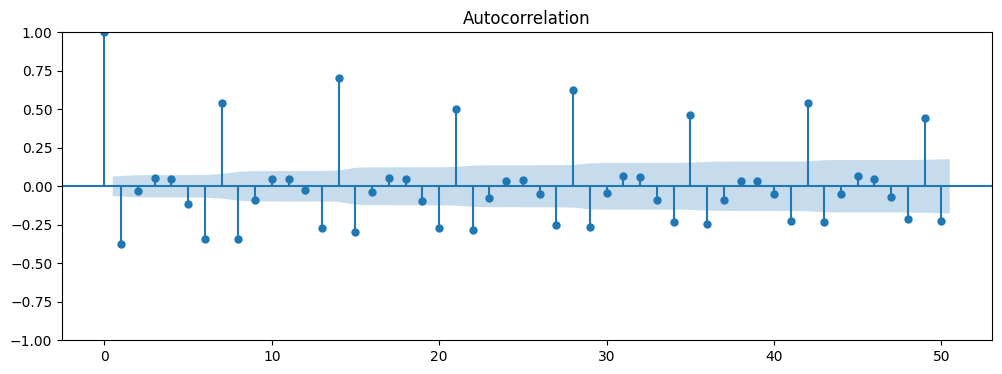

In [46]:
# plot ACF
plt.figure(figsize=(12, 4))
plot_acf(daily_data_boxcox_diff.Sales, ax=plt.gca(), lags=50)
plt.show()

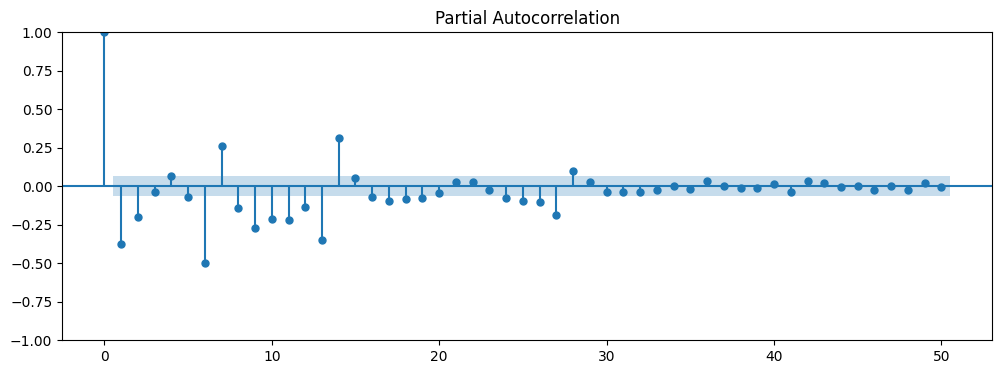

In [47]:
# plot PACF
plt.figure(figsize=(12,4))
plot_pacf(daily_data_boxcox_diff.Sales, ax=plt.gca(), lags=50)
plt.show()

**Observation:**
- The significant drop near lag 7 suggests q=7.
- After lag 1, the PACF cuts off sharply, indicating that no further significant lags are adding value after lag 1.This suggests p=1.

# Johansen Cointegration Test 
---

In [48]:
result = coint_johansen(daily_data_boxcox_diff, det_order=0, k_ar_diff=1)

# Eigenvalue statistics test results
print("Eigenvalue test statistics:")
print(result.lr1)

# Critical values for the test at different significance levels (1%, 5%, 10%)
print("\nCritical values (at 1%, 5%, and 10% levels):")
print(result.cvt)

Eigenvalue test statistics:
[2601.88115751 1353.85990334  454.85463465  146.73185143]

Critical values (at 1%, 5%, and 10% levels):
[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


**Observation:**
- Since all the eigenvalue test statistics exceed the critical values at the 1% significance level (which is the most stringent level), it indicates that all four variables (Sales, Customers, Promo, Promo2) are cointegrated.

# Temporary Model Training:
---

### Train Test Split:
We need to forcast the sales for 42 days so we will fetch those data.

In [49]:
split_date = '2015-06-20' # start of the last week 6
# Split original data
train_data = daily_data[daily_data.index < split_date]
test_data = daily_data[daily_data.index >= split_date]

# split boxcox data
train_data_boxcox = daily_data_boxcox[daily_data_boxcox.index < split_date]
test_data_boxcox = daily_data_boxcox[daily_data_boxcox.index >= split_date]

# split boxcox and differenced data:
train_data_boxcox_diff = daily_data_boxcox_diff[daily_data_boxcox_diff.index < split_date]
test_data_boxcox_diff = daily_data_boxcox_diff[daily_data_boxcox_diff.index >= split_date]

### VAR Model:

In [50]:
# Specify endog and exog
endog = train_data_boxcox_diff[['Sales', 'Customers']]
exog = train_data_boxcox_diff[['Promo', 'Promo2']]

In [51]:
# Determine the optimal lag order:
model = VAR(endog=endog, exog=exog)
lag_order = model.select_order(maxlags=30)
print(lag_order.summary())
optimal_lag = lag_order.aic # store the best lag

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.795      -8.762   0.0001515      -8.782
1       -9.998      -9.943   4.551e-05      -9.977
2       -10.32      -10.25   3.286e-05      -10.29
3       -10.42      -10.32   2.991e-05      -10.38
4       -10.45      -10.33   2.905e-05      -10.40
5       -10.47      -10.33   2.835e-05      -10.42
6       -10.86      -10.70   1.918e-05      -10.80
7       -11.44      -11.25   1.079e-05      -11.37
8       -11.51      -11.30   1.001e-05      -11.43
9       -11.56      -11.33   9.573e-06      -11.47
10      -11.61      -11.36   9.084e-06      -11.51
11      -11.67      -11.40   8.546e-06      -11.57
12      -11.71      -11.41   8.242e-06      -11.59
13      -11.76      -11.44   7.806e-06      -11.64
14      -11.91     -11.57*   6.710e-06      -11.78
15      -11.91      -11.55   6.693e-06      -11.78
16      -11.91      -11.52   6.

In [52]:
# Fit the VAR model
var_model = model.fit(optimal_lag, trend='n')
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Dec, 2024
Time:                     22:08:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.4188
Nobs:                     871.000    HQIC:                  -11.8110
Log likelihood:           2893.75    FPE:                5.82316e-06
AIC:                     -12.0541    Det(Omega_mle):     5.11874e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
Promo                 0.000000         0.000000           14.715           0.000
Promo2               -0.000000         0.000000           -9.121           0.000
L1.Sales             -1.027255         0.056961          -18

In [53]:
# Forecast the 42 days sales
forecast_diff = var_model.forecast(y=endog.values[-var_model.k_ar:], steps=42, exog_future=test_data_boxcox_diff[['Promo', 'Promo2']])

# Create a DataFrame and store the values
forecast_df = pd.DataFrame(forecast_diff, columns=['Sales', 'Customers'], index=test_data_boxcox_diff.index)

# Transform the data to original state:
# Use cumcum() to revert data from differencing
forecast_df['Sales'] = forecast_df['Sales'].cumsum() + train_data_boxcox['Sales'].iloc[-1]  # Add last known value of 'Sales'

# Revert the data from boxcox to original state:
def inverse_boxcox(y_boxcox, lam):
    if lam == 0:
        return np.exp(y_boxcox)  # For lambda = 0, use exp to revert log transformation
    else:
        return (y_boxcox * lam + 1) ** (1 / lam)  # For non-zero lambda, apply the inverse Box-Cox formula

# Apply inverse Box-Cox transformation to revert back to original scale
lambda_sales = lambda_Sales  # Replace with the actual lambda used for Box-Cox transformation of 'Sales'

forecast_df['Sales'] = inverse_boxcox(forecast_df['Sales'], lambda_sales)

### Plot train, test and forecast:
1. For Sales
2. For Customer

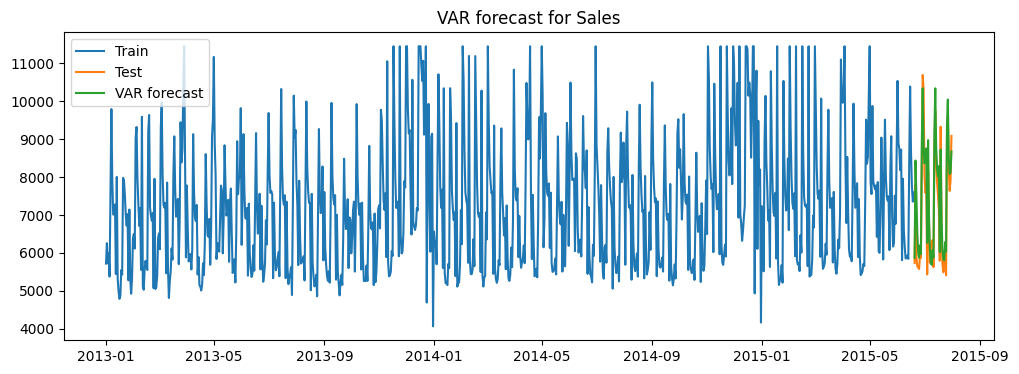

In [54]:
# Plot Figure of actual and forecasted for Sales:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(forecast_df['Sales'][test_data.index.min():], label='VAR forecast')
plt.legend(loc='best')
plt.title('VAR forecast for Sales')
plt.show()

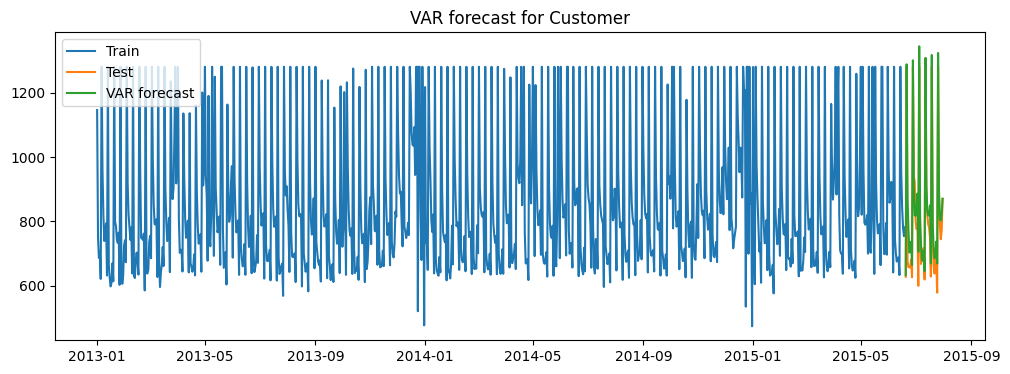

In [55]:
# Plot train, test and forecast for customer:
plt.figure(figsize=(12,4))
plt.plot(train_data['Customers'], label='Train')
plt.plot(test_data['Customers'], label='Test')
plt.plot(forecast_df['Customers'][test_data.index.min():], label='VAR forecast')
plt.legend(loc='best')
plt.title('VAR forecast for Customer')
plt.show()

### VAR Model RMSE and MAPE:

In [56]:
# For Sales:
rmse_sales = np.sqrt(mean_squared_error(test_data['Sales'], forecast_df['Sales'])).round(2)
mape_sales = np.round(np.mean(np.abs(((test_data['Sales'] - forecast_df['Sales'])/test_data['Sales'])*100)), 2)

# For Customer
rmse_cust = np.sqrt(mean_squared_error(test_data['Customers'], forecast_df['Customers'])).round(2)
mape_cust = np.round(np.mean(np.abs(((test_data['Customers'] - forecast_df['Customers'])/test_data['Customers'])*100)), 2)

result = pd.DataFrame({'Method':['VAR Method'], 'RMSE_Sales': [rmse_sales],'RMSE_Customers': [rmse_cust],
                         'MAPE_Sales': [mape_sales], 'MAPE_Customers':[mape_cust]})
result

,Method,RMSE_Sales,RMSE_Customers,MAPE_Sales,MAPE_Customers
0,VAR Method,609.3,61.27,7.2,6.51


### VARMAX Model:
---

In [57]:
varmax_model = VARMAX(endog=endog, exog=exog, order=(1,1), trend='n')
model_fit = varmax_model.fit(disp=False, maxiter=1000)
model_fit.summary()

Dep. Variable:,"['Sales', 'Customers']",No. Observations:,899
Model:,"VARMAX(1,1)",Log Likelihood,867.932
Date:,"Tue, 24 Dec 2024",AIC,-1705.864
Time:,22:09:02,BIC,-1633.845
Sample:,01-02-2013,HQIC,-1678.351
,- 06-19-2015,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"12.20, 18.65",Jarque-Bera (JB):,"167.00, 52.39"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.91, 1.38",Skew:,"0.39, 0.57"
Prob(H) (two-sided):,"0.43, 0.01",Kurtosis:,"4.96, 3.29"


**Note**
- Not Moving ahed with the VARMAX model because of the very high AIC and BIC.

**Colclusion**:
- As per the above observation VAR is the most efficient model for the training in compare with VARMAX model.
- So, in Final Model we will use VAR Model for the forcasting
- RMSE_Sales - 609.3
- RMSE_Customers - 61.27
- MAPE_Sales - 7.2
- MAPE_Customers - 6.51 

# Final Model Training:
---
- We will use complete 942 data to train the model and then do the forcasting for the next 6 weeks
- Using VAR Model for Training

### Train Final VAR Model

In [58]:
# Specify endog and exog
endog_final = daily_data_boxcox_diff[['Sales', 'Customers']]
exog_final = daily_data_boxcox_diff[['Promo', 'Promo2']]

# Determine the optimal lag order:
model = VAR(endog=endog_final, exog=exog_final)
lag_order = model.select_order(maxlags=30)
optimal_lag = lag_order.aic # store the best lag

# Fit the VAR model
var_model = model.fit(optimal_lag, trend='n')
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Dec, 2024
Time:                     22:09:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.4865
Nobs:                     912.000    HQIC:                  -11.8782
Log likelihood:           3058.64    FPE:                5.45074e-06
AIC:                     -12.1201    Det(Omega_mle):     4.79858e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
Promo                 0.000000         0.000000           15.106           0.000
Promo2               -0.000000         0.000000           -9.388           0.000
L1.Sales             -1.027170         0.055892          -18

### Forecast for next 6 weeks
- till 11-09-2015 means 42 days

In [59]:
exog_future = exog_final[899:]
# Forecast the 42 days sales
forecast_diff = var_model.forecast(y=endog_final.values[-var_model.k_ar:], steps=42, exog_future=exog_future[['Promo', 'Promo2']] )

# Create a DataFrame and store the values
forecast_df = pd.DataFrame(forecast_diff, columns=['Sales', 'Customers'],
                           index=pd.date_range(start='2015-08-01', periods=42, freq='D'))

# Transform the data to original state:
# Use cumcum() to revert data from differencing
forecast_df['Sales'] = forecast_df['Sales'].cumsum() + daily_data_boxcox['Sales'].iloc[-1]  # Add last known value of 'Sales'

# Revert the data from boxcox to original state:
def inverse_boxcox(y_boxcox, lam):
    if lam == 0:
        return np.exp(y_boxcox)  # For lambda = 0, use exp to revert log transformation
    else:
        return (y_boxcox * lam + 1) ** (1 / lam)  # For non-zero lambda, apply the inverse Box-Cox formula

# Apply inverse Box-Cox transformation to revert back to original scale
lambda_sales = lambda_Sales  # Replace with the actual lambda used for Box-Cox transformation of 'Sales'

forecast_df['Sales'] = inverse_boxcox(forecast_df['Sales'], lambda_sales)

### Plot Train, and Forecast

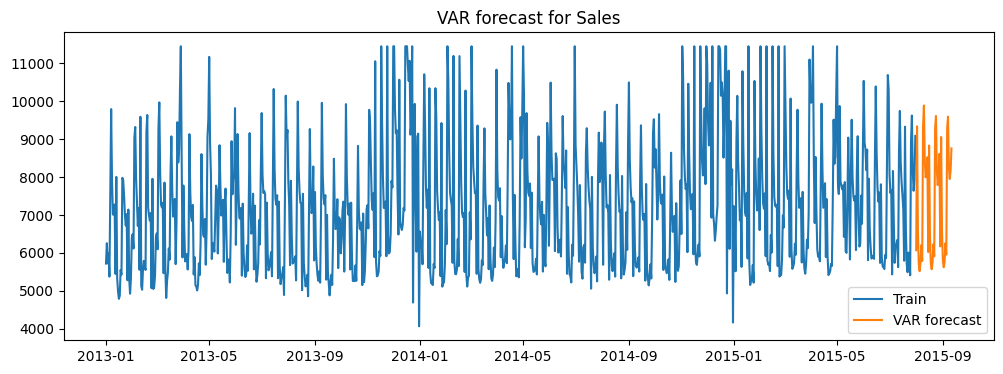

In [60]:
# Plot Figure of actual and forecasted for Sales:
plt.figure(figsize=(12,4))
plt.plot(daily_data['Sales'], label='Train')
plt.plot(forecast_df['Sales'][forecast_df.index.min():], label='VAR forecast')
plt.legend(loc='best')
plt.title('VAR forecast for Sales')
plt.show()

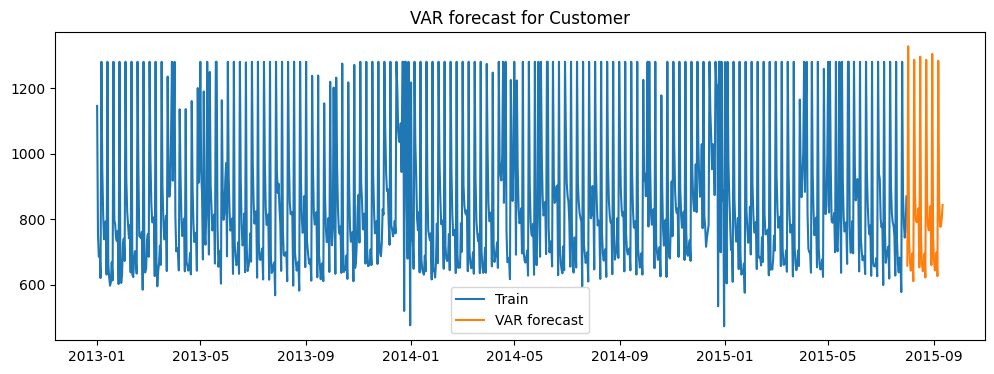

In [61]:
# Plot Figure of actual and forecasted for Customer:
plt.figure(figsize=(12,4))
plt.plot(daily_data['Customers'], label='Train')
plt.plot(forecast_df['Customers'][forecast_df.index.min():], label='VAR forecast')
plt.legend(loc='best')
plt.title('VAR forecast for Customer')
plt.show()

# Final Varmax Forcast plot

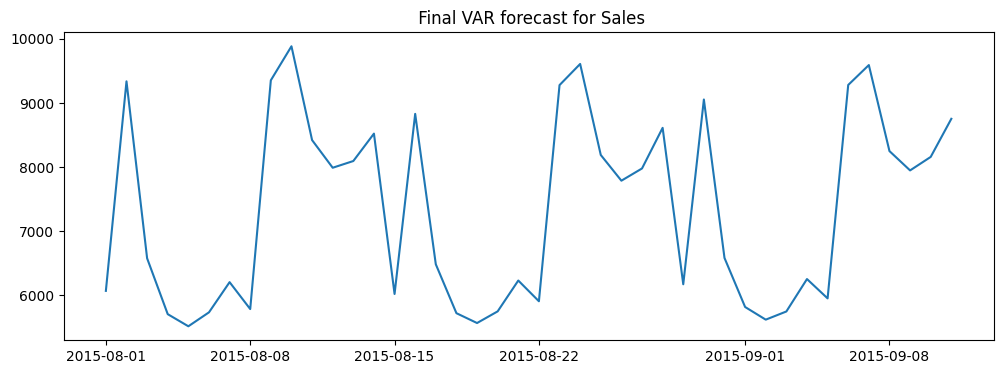

In [62]:
# Plot Figure of actual and forecasted for Sales:
plt.figure(figsize=(12,4))
plt.plot(forecast_df['Sales'][forecast_df.index.min():], label='VAR forecast')
plt.title(' Final VAR forecast for Sales')
plt.show()

# Summary of Findings:
---
**1. Observations for Categorical Data:**
- Shops are experiencing higher demand, indicating that customer traffic and buying activity are concentrated in certain outlets.
- Promotional activities significantly boost sales, highlighting their impact on driving purchases.
- Despite being fewer in number, the 'b' category Assortment maintains consistent average sales, suggesting these shops cater to specific or high-value customer needs.
- Categories with a higher frequency of stores contribute more to overall sales. However, analyzing average sales offers deeper insights into the performance and efficiency of each category.

**2. Observations for Numerical Data:**
- A linear relationship is observed between Customer and Sales, indicating that customer volume has a significant impact on sales.
- Competition vs Sales does not show a notable relationship, suggesting that competition might not directly influence sales in this case.

**3. Impact of Key Variables on Sales:**
- Customer and Promo are the most influential factors impacting Sales, underlining their effectiveness in driving purchases.
- Variables like Sales, Customer, Promo, Promo2, and Assortment_c are directly affecting Sales, and therefore it is advisable to retain only these columns for future analysis and model training.

**4. Stationarity Tests:**
- Sales: The ADF test and KPSS test indicate that Sales is stationary after applying differencing, which is necessary for modeling.
- Customer: Both tests confirm that the Customer column is stationary.
- Promo: The ADF test and KPSS test show that Promo is stationary, making it ready for analysis.
- Promo2: The ADF test and KPSS test suggest that Promo2 was initially non-stationary but is now stationary after transformation.

**5. Model Preparation and Testing:**
- Based on the test results, both Sales and Promo2 are now stationary, allowing the dataset to be ready for model training.
- After analyzing the ACF and PACF plots, it was concluded that p=1 and q=7 are optimal lag parameters for the VAR model.
- Cointegration tests indicate that all four variables (Sales, Customers, Promo, Promo2) are cointegrated, reinforcing the suitability of the VAR model for this data.

**6. Model Selection:**
- VAR has proven to be the most efficient model when compared to VARMAX, making it the ideal choice for the final model.

**7. Model Performance:**
- RMSE (Root Mean Squared Error) for Sales: 609.3
- RMSE for Customers: 61.27
- MAPE (Mean Absolute Percentage Error) for Sales: 7.2%
- MAPE for Customers: 6.51%

**Conclusion:**
The analysis suggests that the VAR model is the best fit for forecasting, providing reliable performance metrics and accurate predictions. With the data now stationary and transformed, the final model is ready to generate valuable insights into Sales and Customer behavior, supported by strong statistical evidence from ADF, KPSS, and cointegration tests.